<a href="https://colab.research.google.com/github/atul1234anand/fastai/blob/master/6way.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.text import *

In [149]:
! git clone https://github.com/Tariq60/LIAR-PLUS.git

fatal: destination path 'LIAR-PLUS' already exists and is not an empty directory.


In [4]:
!ls


LIAR-PLUS  sample_data


In [5]:
path = Path('/content/LIAR-PLUS/dataset')
path.ls()

[PosixPath('/content/LIAR-PLUS/dataset/test2.tsv'),
 PosixPath('/content/LIAR-PLUS/dataset/train2.tsv'),
 PosixPath('/content/LIAR-PLUS/dataset/val2.tsv')]

In [0]:
#df = pd.read_csv('/content/LIAR-PLUS/dataset/trai2.tsv',delimiter='\t',encoding='utf-8', error_bad_lines=False)
#df = pd.read_csv('/content/LIAR-PLUS/dataset/test2.tsv',delimiter='\t',encoding='utf-8', error_bad_lines=False)
df = pd.read_csv('/content/LIAR-PLUS/dataset/val2.tsv',delimiter='\t',encoding='utf-8', error_bad_lines=False)

In [0]:
df.head()

In [0]:
#df = pd.read_csv(file_path, usecols=[3,6], names=['colA', 'colB'])
#data_F = pd.read_csv('/content/LIAR-PLUS/dataset/test2.tsv',delimiter='\t',encoding='utf-8', error_bad_lines=False,usecols=[2,3],names=['label','text'])
#data_F = pd.read_csv('/content/LIAR-PLUS/dataset/test2.tsv',delimiter='\t',encoding='utf-8', error_bad_lines=False,usecols=[2,3],names=['label','text'])
data_F = pd.read_csv('/content/LIAR-PLUS/dataset/val2.tsv',delimiter='\t',encoding='utf-8', error_bad_lines=False,usecols=[2,3],names=['label','text'])

In [25]:
data_F.head()

,label,text
0,barely-true,We have less Americans working now than in the...
1,pants-fire,"When Obama was sworn into office, he DID NOT u..."
2,false,Says Having organizations parading as being so...
3,half-true,Says nearly half of Oregons children are poor.
4,half-true,On attacks by Republicans that various program...


In [0]:
data_F.to_csv('/content/LIAR-PLUS/dataset/val.csv') 

In [0]:
list(df)

In [0]:
data_lm = TextLMDataBunch.from_csv(path, 'train.csv')

In [0]:
data_lm.save('data_lm.pkl')

In [0]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [306]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


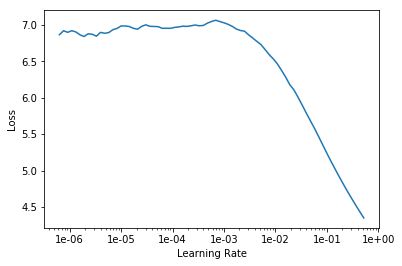

In [307]:
learn.recorder.plot(skip_end=15)

In [308]:
learn.fit_one_cycle(1, slice(1e-3,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.159930,0.654456,0.748143,00:03


In [0]:
learn.unfreeze()

In [310]:
learn.fit_one_cycle(8, slice(1e-3,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.592994,0.551190,0.756571,00:03
1,0.624679,0.544629,0.753571,00:03
2,0.582704,0.546137,0.753286,00:03
3,0.559880,0.545286,0.752286,00:03
4,0.573476,0.542518,0.758143,00:03
5,0.557217,0.541541,0.758143,00:03
6,0.551273,0.540591,0.756143,00:03
7,0.545629,0.541037,0.759000,00:03


In [0]:
learn.save_encoder('fine_tuned_enc')

In [0]:
data_class = TextDataBunch.from_csv(path, 'train.csv',vocab = data_lm.vocab,test = 'test.csv',text_cols = 'text',label_cols = 'label')

In [313]:
data_class.show_batch()

text,target
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk - xxunk xxunk xxunk xxunk xxwrep xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk false xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk - xxunk xxunk xxunk - xxunk xxunk xxmaj xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk,true
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk - xxunk xxunk xxmaj xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxup xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxmaj xxunk xxunk xxmaj xxunk,false
xxbos xxmaj xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxmaj xxunk,mostly-true
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk,true
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk - xxunk xxunk xxunk xxunk xxunk - xxunk xxunk xxmaj xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj,false


In [0]:
data_class.save('data_class.pk1')

In [0]:
data_clas = load_data(path, 'data_class.pk1', bs=bs)

In [0]:
learner = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learner.load_encoder('fine_tuned_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


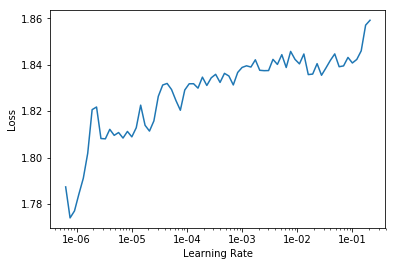

In [324]:
learner.lr_find()
learner.recorder.plot(skip_end=15)

In [328]:
learner.fit_one_cycle(2, slice(1e-4,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.779709,1.746546,0.212787,00:20
1,1.763405,1.741642,0.219131,00:19


In [329]:
learner.save('first')
learner.load('first')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (8191 items)
x: TextList
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk,xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk,xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk,xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk - xxunk xxunk xxunk,xxbos xxmaj xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk
y: CategoryList
barely-true,barely-true,half-true,false,half-true
Path: /content/LIAR-PLUS/dataset;

Valid: LabelList (2049 items)
x: TextList
xxbos xxmaj xxunk xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk,xxbos xxmaj xxu

In [330]:
learner.freeze_to(-2)
learner.fit_one_cycle(1, slice(1e-4,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.765917,1.743225,0.211323,00:21


In [331]:
learn.save('second')
learn.load('second')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (8191 items)
x: TextList
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk,xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk,xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk,xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk - xxunk xxunk xxunk,xxbos xxmaj xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk
y: CategoryList
barely-true,barely-true,half-true,false,half-true
Path: /content/LIAR-PLUS/dataset;

Valid: LabelList (2049 items)
x: TextList
xxbos xxmaj xxunk xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk,xxbos xxmaj xxu

In [333]:
learner.freeze_to(-3)
learner.fit_one_cycle(1, slice(1e-4,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.761651,1.739718,0.220107,00:32


In [336]:
learner.unfreeze()
learner.fit_one_cycle(5, slice(1e-4,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.748545,1.743202,0.214251,00:39
1,1.751866,1.742318,0.209370,00:37
2,1.758174,1.752825,0.207906,00:39
3,1.754465,1.745375,0.205954,00:40
4,1.744290,1.740576,0.208394,00:37


In [0]:
learn.save_encoder('fine_tuned_enc')

In [0]:
data_val = TextDataBunch.from_csv(path, 'train.csv',vocab = data_lm.vocab,test = 'val.csv',text_cols = 'text',label_cols = 'label')

In [338]:
data_val.show_batch()

text,target
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk - xxunk xxunk xxunk - xxunk xxunk xxmaj xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk,mostly-true
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk - xxunk xxunk xxmaj xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxup xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxmaj xxunk xxunk xxmaj xxunk,false
xxbos xxmaj xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxmaj xxunk,mostly-true
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk - xxunk xxunk xxunk - xxunk xxunk xxunk - xxunk xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk half - true xxunk xxunk,barely-true
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk,barely-true


In [0]:
data_val.save('data_val.pk1')
data_val = load_data(path, 'data_val.pk1', bs=bs)

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3)
learn.load_encoder('fine_tuned_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


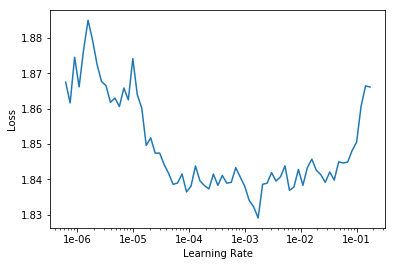

In [341]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [342]:
learn.fit_one_cycle(2, slice(1e-4,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.773003,1.746843,0.212299,00:19
1,1.762196,1.743075,0.206442,00:20


In [343]:
learn.save('first')
learn.load('first')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (8191 items)
x: TextList
xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk,xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk,xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk,xxbos xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxunk xxunk xxunk xxunk - xxunk xxunk xxunk,xxbos xxmaj xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk
y: CategoryList
barely-true,barely-true,half-true,false,half-true
Path: /content/LIAR-PLUS/dataset;

Valid: LabelList (2049 items)
x: TextList
xxbos xxmaj xxunk xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxmaj xxunk xxmaj xxunk xxunk xxunk,xxbos xxmaj xxu

In [344]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, slice(1e-4,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.759157,1.742611,0.204490,00:22
1,1.746420,1.743660,0.209858,00:20


In [0]:
learn.save('second')
learn.load('second')

In [346]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, slice(1e-4,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.749994,1.741559,0.212787,00:32
1,1.751202,1.738481,0.205466,00:29


In [348]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-4,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.756855,1.739257,0.211811,00:39
1,1.748763,1.824186,0.200098,00:40
2,1.760786,1.748486,0.211323,00:39
3,1.749490,1.747254,0.204002,00:37
4,1.746512,1.740597,0.210835,00:39
